# CLASSIFICATION MODELS

First we will load the datasets we are going to use in our models. Which are the OSA database and the extreme_male database.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RepeatedKFold,cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from six import StringIO
from IPython.display import Image  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
df_male_xlsx = r'C:\Users\Usuario\universidad\MUIT\2º\MLLB\OSA CASE STUDY\R\DATA\OSA_extreme_male.xlsx'
df_male = pd.read_excel(df_male_xlsx)
df_male.head()

,Patient,Gender,IAH,Weight,Height,Age,Cervical,OSA,BMI
0,P0005,hombre,9.0,80,173,32,40,Healthy,26.729927
1,P0006,hombre,2.0,109,190,32,42,Healthy,30.193906
2,P0007,hombre,34.0,86,169,39,42,Severe,30.110991
3,P0008,hombre,60.0,145,172,47,44,Severe,49.012980
4,P0013,hombre,3.7,90,180,36,40,Healthy,27.777778


Now we are going to clear the datasets in order to only use the features that are useful for us.  We are going to load the daraframe of extreme male cases because it allow us to do a binary classification. (Luego probar con la df_final conviertiendo a OSA en binary)

In [3]:
df_male = df_male.drop(columns=['Patient', 'IAH', 'Gender', 'Height'])

We prepare the data to store the results and to select the features and convert them into a numeric form that scikit learn models understand 

In [4]:
results = []
X = df_male[['Weight', 'Cervical', 'BMI', 'Age']].to_numpy()

# Lets turn into numerical values our non-numerical features
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(df_male['OSA'])

### Nested Loop

We are going to apply K-Folds. 
Three common tactics for choosing a value for k are as follows:
- Representative: The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.
- k=10: The value for k is fixed to 10, a value that has been found through experimentation to generally result in a model skill estimate with low bias a modest variance.
- k=n: The value for k is fixed to n, where n is the size of the dataset to give each test sample an opportunity to be used in the hold out dataset. This approach is called leave-one-out cross-validation.

Para la búsqueda de hiperparámetros:
- GridSearchCV:
- RandomizedSearchCV:
- Bayesian Optimization:
- Optuna:
- Hyperopt:
- Sklearn's HalvingGridSearchCV:

In [6]:
# Create the scorer for the classification models. 
# scorer = metrics.make_scorer(metrics.)

def nested_kfolds(X: np.ndarray, y: np.ndarray, model, space: dict, scorer:callable):
    # Configure the OUTER cross-validation procedure
    cv_outer = KFold(n_splits = 3, shuffle = True, random_state=1)
    # enumerate splits
    outer_results = list()
    final_best_model = None
    final_best_params = None
    max_score = float("-inf")
    
    
    # OUTER LOOP =======================================
    for train_ix, test_ix in cv_outer.split(X):
        X_train, X_test = X[train_ix, :], X[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]
    
        # INNER LOOP ===================================
        # configure the INNER cross-validation procedure
        cv_inner = KFold(n_splits = 3, shuffle = True, random_state = 1) # The number of splits should be less in the inner split
        model = model 
        
        if not space:
            best_model = model.fit(X_train, y_train)
            # Evaluate the model
            score = scorer(best_model, X_test, y_test)
            # Store the results
            yhat = best_model.predict(X_test)
          
            # Confussion Matrix
            cm = confusion_matrix(y_test, yhat)
          
          
            # Accuracy, Recall, Precission, F1
            acc = accuracy_score(y_test, yhat)
            rec = recall_score(y_test, yhat)
            prec = precision_score(y_test, yhat)
            f1 = f1_score(y_test, yhat)
            outer_results.append((acc, rec, prec, f1))
            
            # Report Progress
            #print('>acc=%.3f, rec=%.3f, prec=%.3f, f1=%.3f' % (acc, rec, prec, f1))
            print('>Accuracy=%d, Recall=%d, Precission=%d, F1 Score=%d' % (acc, rec, prec, f1))

            # Update best model
            if score > max_score:
                max_score = score
                final_best_model = best_model
                final_best_params = {} 
            

        else:
           cv_inner = KFold(n_splits = 3, shuffle = True, random_state = 1)
           # Define search
           search = GridSearchCV(model, space, scoring = scorer, cv = cv_inner, refit = True)
           # Execute the search
           result = search.fit(X_train, y_train)
           
           # If you want to check the score metric obtained for each hyper-parameter
           ## Comment if you don't want to check this ##
        #    print("Grid search results:")
        #    for params, mean_score, std_score in zip(result.cv_results_['params'], 
        #         result.cv_results_['mean_test_score'],
        #         result.cv_results_['std_test_score']):
        #         print(f"Parameters: {params}, Mean Score: {mean_score}, Std Score: {std_score}")

           # Best performing model fit
           best_model = result.best_estimator_
           # Evaluate the model
           score = scorer(best_model, X_test, y_test)
           # Store the results
           yhat = best_model.predict(X_test)
           
           # Confussion Matrix
           cm = confusion_matrix(y_test, yhat)
          
        
           # Accuracy, Recall, Precision, F1
           acc = accuracy_score(y_test, yhat)
           rec = recall_score(y_test, yhat)
           prec = precision_score(y_test, yhat)
           f1 = f1_score(y_test, yhat)
           outer_results.append((acc, rec, prec, f1))
           
           # Report Progress
           print('>Accuracy=%.3f, Recall=%.3f, Precission=%.3f, F1 Score=%.3f' % (acc, rec, prec, f1))

            # Update best model
           if score > max_score:
                max_score = score
                final_best_model = best_model
                final_best_params = result.best_params_

                
    # Summarize the estimated performance of the model 
    avg_score, std_score = dict(), dict()
    for i, metric_values in enumerate(zip(*outer_results)):
        metric_name = ['Accuracy', 'Recall', 'Precission', 'F1 Score'][i]
        avg_score[metric_name] = np.mean(metric_values)
        std_score[metric_name] = np.std(metric_values)
        
        # Estadísticas resumen de las evaluaciones del
        print('%s: %.3f (%.3f)' % (metric_name, avg_score[metric_name], std_score[metric_name]))
        
    return final_best_model, final_best_params, avg_score, std_score, outer_results, cm

Function to plot the confussion matrix

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap='Blues'):
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

Function to obtain the coefficients, which will tell us how related one coefficient is to another.

In [8]:
def get_coefs(X, y, model, space, scorer):
    final_best_model, _, _, _, _, _ = nested_kfolds(X, y, model, space, scorer)
    coefs = final_best_model.coef_
    return coefs

Function to represent the obtained metrics

In [9]:
def plot_scores(metrics, average_scores, std_dev_scores):
    # Configurar el gráfico
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = range(len(metrics))

    # Dibujar las barras de promedio
    bars1 = ax.bar(index, average_scores, bar_width, label='Average Scores', yerr=std_dev_scores, capsize=5)

    # Configurar etiquetas y título
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Average Scores with Standard Deviations')
    ax.set_xticks(index)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Mostrar el gráfico
    plt.show()


Function to represent the coefficients

In [10]:
def plot_coefficients(names, coefficients):
    sns.set(rc={"figure.figsize":(10, 5)})
    sns.barplot(x=names, y=coefficients[0])
    plt.show()

Function to plot the accuracy obtained in each fold

In [11]:
def plot_accuracy_across_folds(outer_results):
    accuracy_per_fold = [acc for acc, _, _, _ in outer_results]
    print(accuracy_per_fold)
    
    sns.boxplot(x=['Fold 1', 'Fold 2', 'Fold 3'], y=accuracy_per_fold)
    plt.title('Accuracy Across Folds')
    plt.ylabel('Accuracy')
    plt.show()

### Logistic Regression (Ridge)

Supervised model used for binary classifications. The objetive of this model is to predict the probability that a feature corresponds to a particular class. The objective is to find the coeficients that minimize the cost function.
We are going to use cross validation in order to make our model more robust in the training/evaluation process.

We have used a 'solver' which is the algorithm used to optimize the model's parameters. Logistic regression uses optimization to ajust the model's coefficients to the training data. 
- Liblinear: Recommended for small dataset
- Newton.CG: Recommended for big dataset
- Sag: This uses the stochastic gradient. Efficient for big data set
- Saga: A better version of 'Sag' that also allows elastic penalization

In our case it makes sense to use 'Liblinear' as we are using a relatively small dataset. 

Explicar el space, es donde definimos los hiperparámetros (explicar en el caso particular de logistic regression). 
- C = regularization strength 


In [12]:
## Logistic Regression
from sklearn import preprocessing, metrics
scorer_logistic = metrics.make_scorer(accuracy_score)
model_logistic = LogisticRegression(solver = "liblinear", random_state = 1)
space_logistic = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}


final_best_model_logistic, final_best_params_logistic, avg_score_logistic, std_score_logistic, outer_results_logistic, cm_logistic = nested_kfolds(X=X, y=y, space = space_logistic, scorer = scorer_logistic, model = model_logistic)


print("Final Best Parameters:", final_best_params_logistic)
print("Final Best Model:", final_best_model_logistic)
print("Average Scores:", avg_score_logistic)
print("Standard Deviations of Scores:", std_score_logistic)
print("Confussion Matrix:", cm_logistic)


>Accuracy=0.656, Recall=0.556, Precission=0.676, F1 Score=0.610
>Accuracy=0.763, Recall=0.830, Precission=0.736, F1 Score=0.780
>Accuracy=0.707, Recall=0.622, Precission=0.737, F1 Score=0.675
Accuracy: 0.709 (0.044)
Recall: 0.669 (0.117)
Precission: 0.716 (0.029)
F1 Score: 0.688 (0.070)
Final Best Parameters: {'C': 100}
Final Best Model: LogisticRegression(C=100, random_state=1, solver='liblinear')
Average Scores: {'Accuracy': 0.7086255259467041, 'Recall': 0.6691883372734436, 'Precission': 0.716122279180869, 'F1 Score': 0.6881516309138996}
Standard Deviations of Scores: {'Accuracy': 0.0439228642991026, 'Recall': 0.11677646835929012, 'Precission': 0.028602940848098304, 'F1 Score': 0.07014974778460188}
Confussion Matrix: [[37 10]
 [17 28]]


After analysing the metrics we are going to obtain the coefficients

In [18]:
coefs_logistic = get_coefs(X, y, model_logistic, space_logistic, scorer_logistic)
print("Coefficients", coefs_logistic)

>Accuracy=0.656, Recall=0.556, Precission=0.676, F1 Score=0.610
>Accuracy=0.763, Recall=0.830, Precission=0.736, F1 Score=0.780
>Accuracy=0.707, Recall=0.622, Precission=0.737, F1 Score=0.675
Accuracy: 0.709 (0.044)
Recall: 0.669 (0.117)
Precission: 0.716 (0.029)
F1 Score: 0.688 (0.070)
Coefficients [[0.04286888 0.0152258  0.05047921 0.06442699]]


Ploting the metrics, the confussion matrix and the coefficients

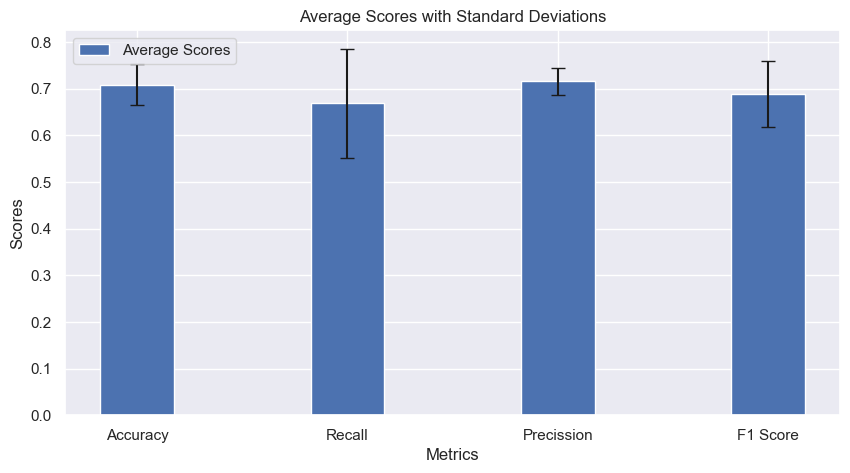

In [216]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_logistic[metric] for metric in metrics]
std_dev_scores = [std_score_logistic[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)


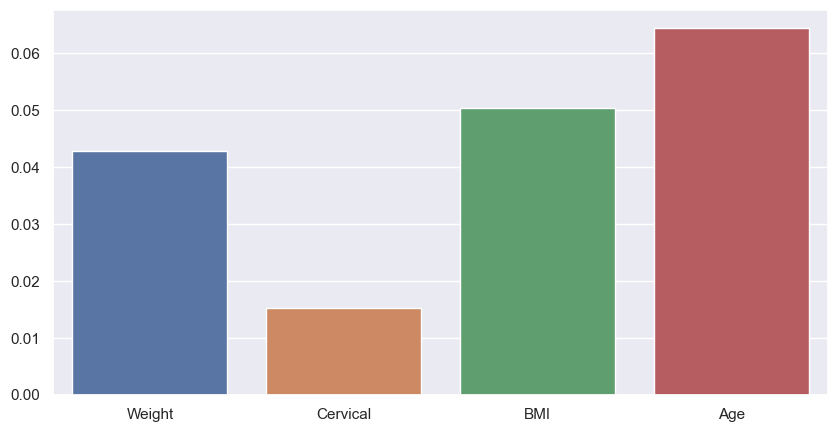

In [19]:
names = ['Weight', 'Cervical', 'BMI', 'Age']
coefficients = coefs_logistic

plot_coefficients(names, coefficients)

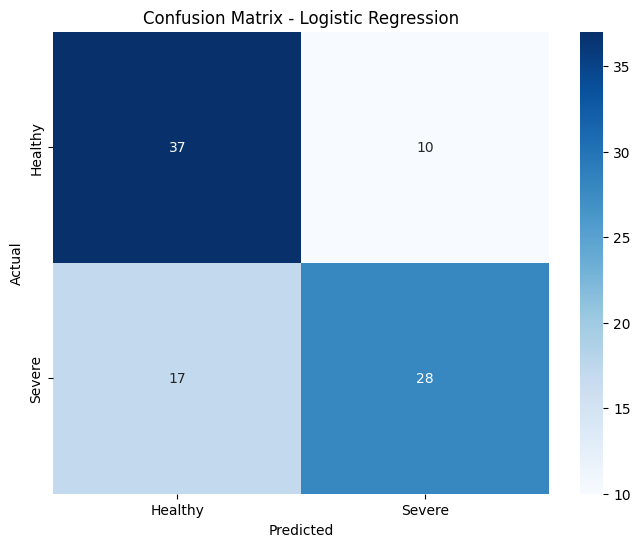

In [13]:
plot_confusion_matrix(cm_logistic, classes=['Healthy', 'Severe'], title='Confusion Matrix - Logistic Regression')

### Lasso Regression

 The Lasso regression model is designed for regression tasks, and the mentioned metrics are suitable for classification problems where predicting a class label is involved.

If you are working on a classification problem (as mentioned earlier regarding OSA severity), then the Lasso regression model would not be the appropriate choice for your task.

If you are genuinely interested in utilizing Lasso for classification, you might consider using it in conjunction with L1 regularization in Logistic Regression (LogisticRegression(penalty='l1')). Logistic Regression with L1 regularization is a form of logistic regression with L1 regularization (Lasso), making it more suitable for a classification problem.

https://machinelearningmastery.com/lasso-regression-with-python/ 

In [14]:
from sklearn import preprocessing, metrics
# Modelo de regresión logística con regularización L1 (Lasso)
scorer_lasso = metrics.make_scorer(accuracy_score)
model_lasso = LogisticRegression(penalty = 'l1', solver = "liblinear", random_state = 1)
# Hemos probado a utilizar un numero de iteraciones más bajas pero no eran suficientes ya que el modelo no convergía. 
space_lasso = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
         'max_iter': [500, 1000, 2000],
         }
final_best_model_lasso, final_best_params_lasso, avg_score_lasso, std_score_lasso, outer_results_lasso, cm_lasso = nested_kfolds(X=X, y=y, space = space_lasso, scorer = scorer_lasso, model = model_lasso)

print("Final Best Parameters:", final_best_params_lasso)
print("Final Best Model:", final_best_model_lasso)
print("Average Scores:", avg_score_lasso)
print("Standard Deviations of Scores:", std_score_lasso)
print("Confussion Matrix:", cm_lasso)

>Accuracy=0.656, Recall=0.556, Precission=0.676, F1 Score=0.610
>Accuracy=0.774, Recall=0.830, Precission=0.750, F1 Score=0.788
>Accuracy=0.717, Recall=0.689, Precission=0.721, F1 Score=0.705
Accuracy: 0.716 (0.048)
Recall: 0.691 (0.112)
Precission: 0.716 (0.031)
F1 Score: 0.701 (0.073)
Final Best Parameters: {'C': 10, 'max_iter': 500}
Final Best Model: LogisticRegression(C=10, max_iter=500, penalty='l1', random_state=1,
                   solver='liblinear')
Average Scores: {'Accuracy': 0.7158329437431822, 'Recall': 0.6914105594956658, 'Precission': 0.7155353027446051, 'F1 Score': 0.7007267799950728}
Standard Deviations of Scores: {'Accuracy': 0.048300003652985986, 'Recall': 0.11196881258766007, 'Precission': 0.030581642067712887, 'F1 Score': 0.0727683993136449}
Confussion Matrix: [[35 12]
 [14 31]]


In [20]:
coefs_lasso = get_coefs(X, y, model_lasso, space_lasso, scorer_lasso)
print("Coefficients", coefs_lasso)

>Accuracy=0.656, Recall=0.556, Precission=0.676, F1 Score=0.610
>Accuracy=0.774, Recall=0.830, Precission=0.750, F1 Score=0.788
>Accuracy=0.717, Recall=0.689, Precission=0.721, F1 Score=0.705
Accuracy: 0.716 (0.048)
Recall: 0.691 (0.112)
Precission: 0.716 (0.031)
F1 Score: 0.701 (0.073)
Coefficients [[0.0431625  0.01305306 0.05007226 0.06443434]]


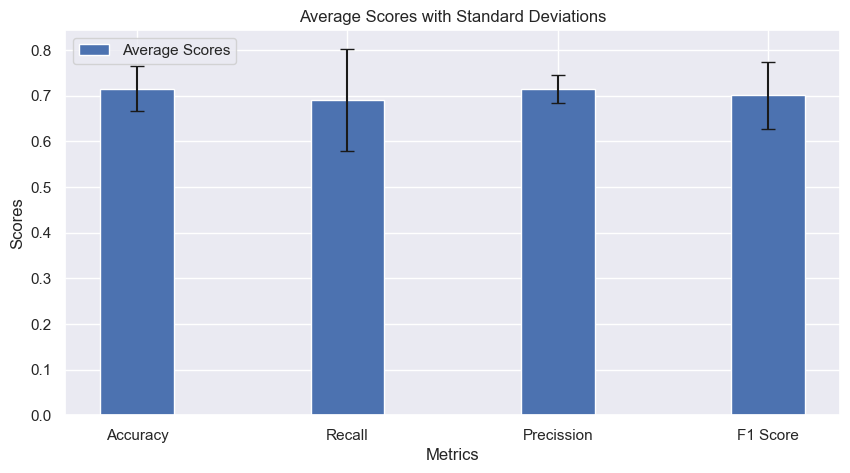

In [220]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_lasso[metric] for metric in metrics]
std_dev_scores = [std_score_lasso[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

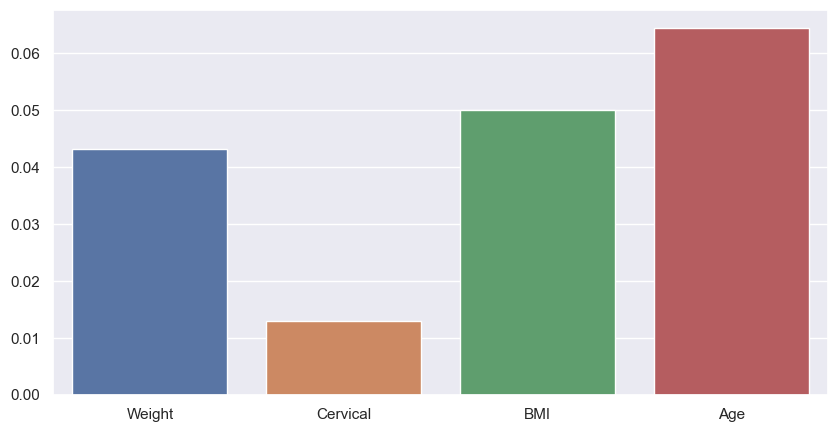

In [221]:
names = ['Weight', 'Cervical', 'BMI', 'Age']
coefficients = coefs_lasso

plot_coefficients(names, coefficients)

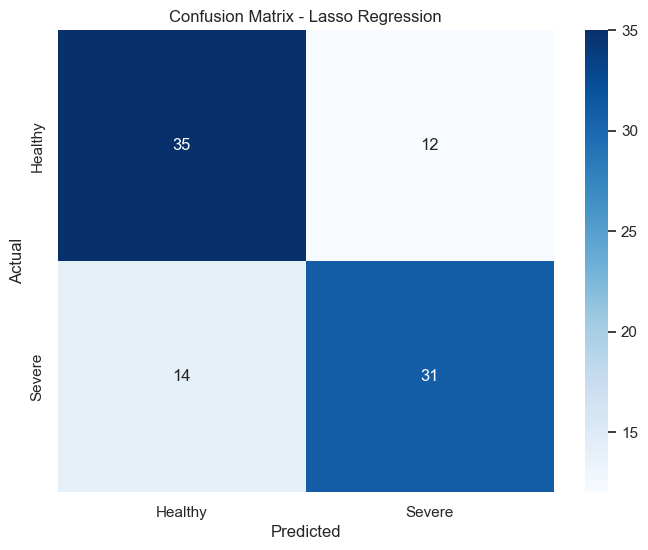

In [21]:
plot_confusion_matrix(cm_lasso, classes=['Healthy', 'Severe'], title='Confusion Matrix - Lasso Regression')

### Elastic Net

Elastic Net method is useful when dealing with datasets where multiple features are highly correlated. It combines the feature selection capability of Lasso with the regularization stability of Ridge, providing a balance between the two.
**¡¡ ONLY SAGA SUPPORTS ELASTIC NET !!**

In [22]:
from sklearn import preprocessing, metrics
scorer_elastic = metrics.make_scorer(accuracy_score)
model_elastic = LogisticRegression(penalty='elasticnet', solver='saga')
# Hemos tenido que aumentar mucho el numero de iteraciones máximas porque sino no convergían
space_elastic = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
         'max_iter': [10000, 20000, 50000],
         'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9],
         }
final_best_model_elastic, final_best_params_elastic, avg_score_elastic, std_score_elastic, outer_results_elastic, cm_elastic = nested_kfolds(X=X, y=y, space = space_elastic, scorer = scorer_elastic, model = model_elastic)

print("Final Best Parameters:", final_best_params_elastic)
print("Final Best Model:", final_best_model_elastic)
print("Average Scores:", avg_score_elastic)
print("Standard Deviations of Scores:", std_score_elastic)
print("Confussion Matrix:", cm_elastic)

>Accuracy=0.570, Recall=0.533, Precission=0.558, F1 Score=0.545
>Accuracy=0.645, Recall=0.766, Precission=0.621, F1 Score=0.686
>Accuracy=0.707, Recall=0.644, Precission=0.725, F1 Score=0.682
Accuracy: 0.641 (0.056)
Recall: 0.648 (0.095)
Precission: 0.635 (0.069)
F1 Score: 0.638 (0.065)
Final Best Parameters: {'C': 0.1, 'l1_ratio': 0.1, 'max_iter': 10000}
Final Best Model: LogisticRegression(C=0.1, l1_ratio=0.1, max_iter=10000, penalty='elasticnet',
                   solver='saga')
Average Scores: {'Accuracy': 0.640525167523765, 'Recall': 0.6479117415287629, 'Precission': 0.6346097300187116, 'F1 Score': 0.6378405907817671}
Standard Deviations of Scores: {'Accuracy': 0.055874915711848966, 'Recall': 0.09500003913799628, 'Precission': 0.06882795007601754, 'F1 Score': 0.06534121051668228}
Confussion Matrix: [[36 11]
 [16 29]]


In [223]:
coefs_elastic = get_coefs(X, y, model_elastic, space_elastic, scorer_elastic)
print("Coefficients", coefs_elastic)

>Accuracy=0.570, Recall=0.533, Precission=0.558, F1 Score=0.545
>Accuracy=0.763, Recall=0.830, Precission=0.736, F1 Score=0.780
>Accuracy=0.707, Recall=0.644, Precission=0.725, F1 Score=0.682
Accuracy: 0.680 (0.081)
Recall: 0.669 (0.122)
Precission: 0.673 (0.081)
F1 Score: 0.669 (0.096)
Coefficients [[0.0120605  0.         0.         0.00905901]]


Los coeficientes nulos se pueden deber a que con Elastic Net estamos utilizando penalizaciones como L1(Lasso), en combinación con la penalización L2(Ridge). La característica distintiva de L1 es su capacidad para llevar algunos coeficientes exactamente a cero, útil para realizar la selección de características útiles para la tarea

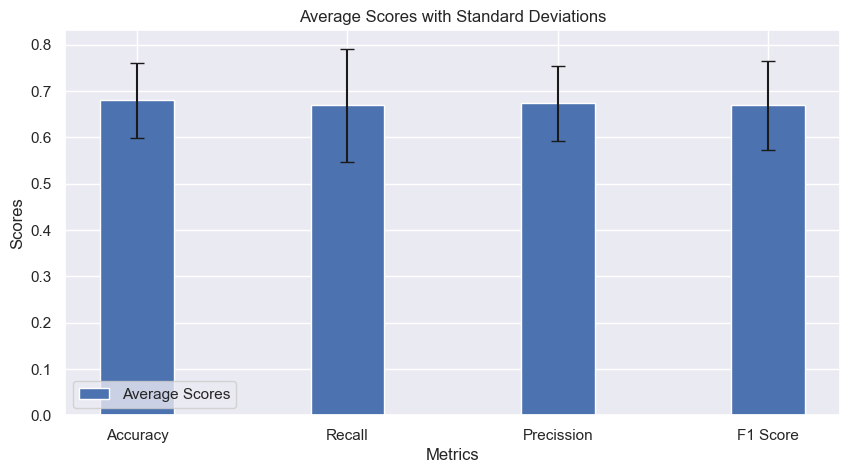

In [224]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_elastic[metric] for metric in metrics]
std_dev_scores = [std_score_elastic[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

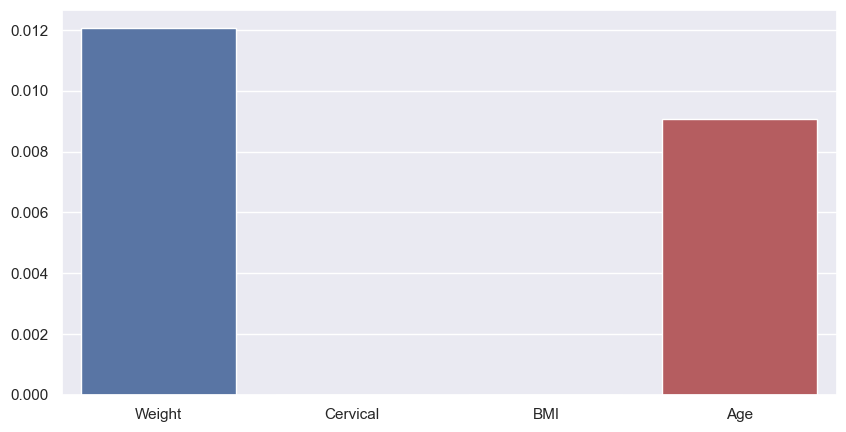

In [225]:
names = ['Weight', 'Cervical', 'BMI', 'Age']
coefficients = coefs_elastic

plot_coefficients(names, coefficients)

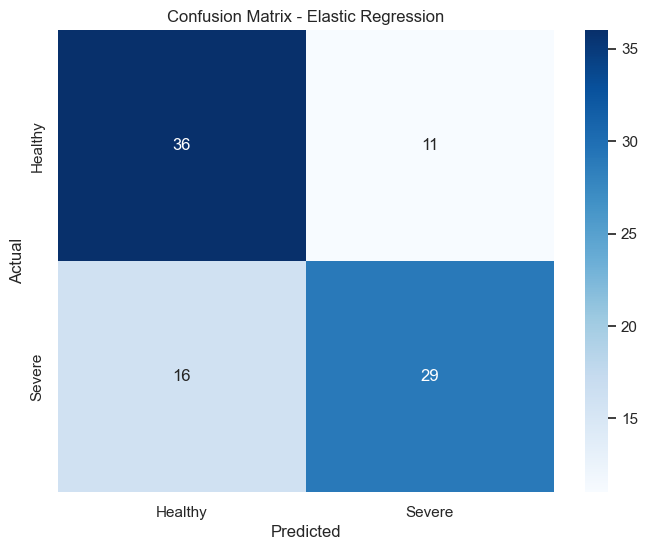

In [23]:
plot_confusion_matrix(cm_elastic, classes=['Healthy', 'Severe'], title='Confusion Matrix - Elastic Regression')

### K-Nearest Neighbors (kNN) with Nested Cross Validation

In [24]:
from sklearn import preprocessing, metrics

# Define the model
scorer_knn = metrics.make_scorer(accuracy_score)
model_knn = KNeighborsClassifier()
space_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # 1 para distancia de Manhattan, 2 para distancia euclidiana
}

final_best_model_knn, final_best_params_knn, avg_score_knn, std_score_knn, outer_results_knn, cm_knn = nested_kfolds(X=X, y=y, space=space_knn, scorer=scorer_knn, model=model_knn)

print("Final Best Parameters:", final_best_params_knn)
print("Final Best Model:", final_best_model_knn)
print("Average Scores:", avg_score_knn)
print("Standard Deviations of Scores:", std_score_knn)
print("Confussion Matrix:", cm_knn)

>Accuracy=0.731, Recall=0.778, Precission=0.700, F1 Score=0.737
>Accuracy=0.634, Recall=0.638, Precission=0.638, F1 Score=0.638
>Accuracy=0.717, Recall=0.756, Precission=0.694, F1 Score=0.723
Accuracy: 0.694 (0.043)
Recall: 0.724 (0.061)
Precission: 0.677 (0.028)
F1 Score: 0.700 (0.044)
Final Best Parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Final Best Model: KNeighborsClassifier(n_neighbors=9, weights='distance')
Average Scores: {'Accuracy': 0.6943275673990962, 'Recall': 0.7238770685579197, 'Precission': 0.6773918077869445, 'F1 Score': 0.6995147443075774}
Standard Deviations of Scores: {'Accuracy': 0.04274157309353763, 'Recall': 0.0611899006320908, 'Precission': 0.027756355871516127, 'F1 Score': 0.04363311443434846}
Confussion Matrix: [[32 15]
 [11 34]]


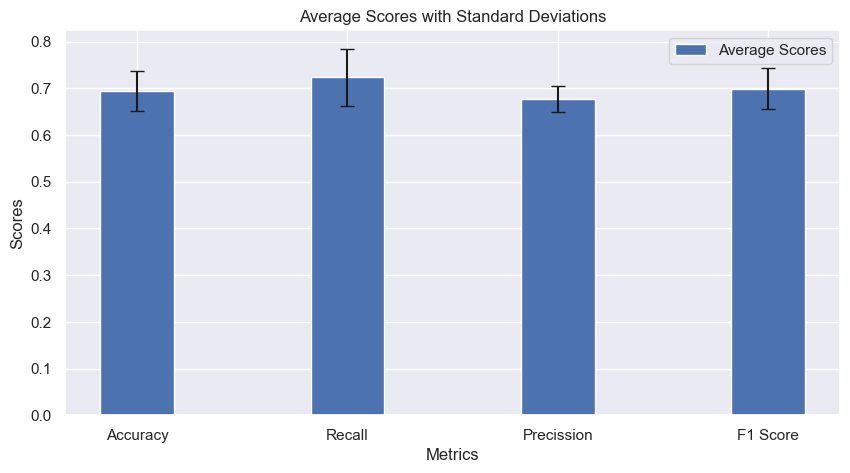

In [25]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_knn[metric] for metric in metrics]
std_dev_scores = [std_score_knn[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

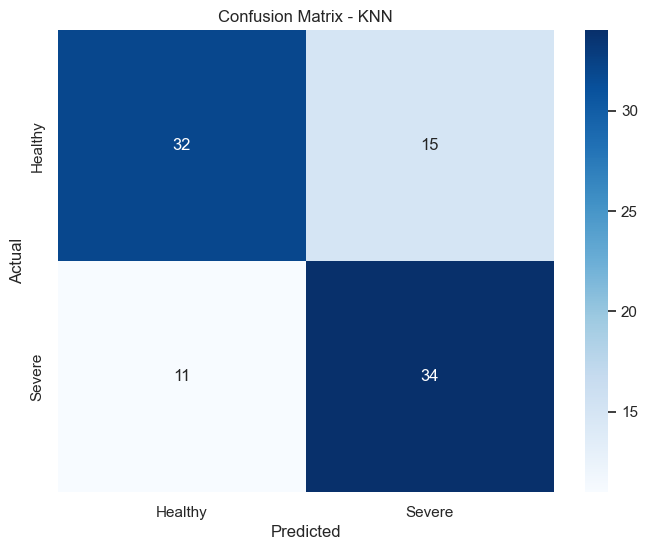

In [26]:
plot_confusion_matrix(cm_knn, classes=['Healthy', 'Severe'], title='Confusion Matrix - KNN')

### KNN with PCA without Nested Cross Validation

KNN con PCA para reducir la dimensionalidad de los datos utilizando PCA antes de aplicar el algoritmo de KNN. PCA ayuda a reducir la cantidad de características mientras mantiene la mayor parte de la variabilidad en los datos.

In [27]:
# Define the space search
space = {
    'pca__n_components': [None, 2, 3, 4],
    'knn__n_neighbors': [3, 5, 7, 9, 10],
}

# Combine the standarization of the data the KNN and the PCA in a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

# We will use GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, space, cv=3, scoring='accuracy')
grid_search.fit(X,y)

# The best parameters and the best model
best_params =grid_search.best_params_
best_model = grid_search.best_estimator_

print("Mejores Parámetros:", best_params)
print("Modelo Final:", best_model)

Mejores Parámetros: {'knn__n_neighbors': 7, 'pca__n_components': 2}
Modelo Final: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('knn', KNeighborsClassifier(n_neighbors=7))])


Lets check the recall, precission, f1 score their means and standard deviations

In [28]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba (puedes ajustar esto según tus necesidades)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Entrenar el mejor modelo con los mejores parámetros en el conjunto de entrenamiento
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

Accuracy: 0.6607142857142857
Recall: 0.7
Precision: 0.6774193548387096
F1 Score: 0.6885245901639343


### Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, metrics

# Define el modelo
scorer_tree = metrics.make_scorer(accuracy_score)
model_tree = DecisionTreeClassifier(random_state=1)

# Define el espacio de búsqueda
space_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Realiza la búsqueda de cuadrícula y obtén los resultados
final_best_model_tree, final_best_params_tree, avg_score_tree, std_score_tree, outer_results_tree, cm_tree = nested_kfolds(X=X, y=y, space=space_tree, scorer=scorer_tree, model=model_tree)

# Imprime los resultados
print("Final Best Parameters:", final_best_params_tree)
print("Final Best Model:", final_best_model_tree)
print("Average Scores:", avg_score_tree)
print("Standard Deviations of Scores:", std_score_tree)
print("Confussion Matrix:", cm_tree)

>Accuracy=0.548, Recall=0.511, Precission=0.535, F1 Score=0.523
>Accuracy=0.667, Recall=0.766, Precission=0.643, F1 Score=0.699
>Accuracy=0.685, Recall=0.756, Precission=0.654, F1 Score=0.701
Accuracy: 0.633 (0.060)
Recall: 0.678 (0.118)
Precission: 0.611 (0.054)
F1 Score: 0.641 (0.084)
Final Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Final Best Model: DecisionTreeClassifier(max_depth=5, random_state=1)
Average Scores: {'Accuracy': 0.6332787907121707, 'Recall': 0.6775413711583923, 'Precission': 0.6105290058778431, 'F1 Score': 0.6409291089253055}
Standard Deviations of Scores: {'Accuracy': 0.060481383436799784, 'Recall': 0.11776055771483604, 'Precission': 0.05367709903818729, 'F1 Score': 0.08358531514914512}
Confussion Matrix: [[29 18]
 [11 34]]


Let's plot the tree

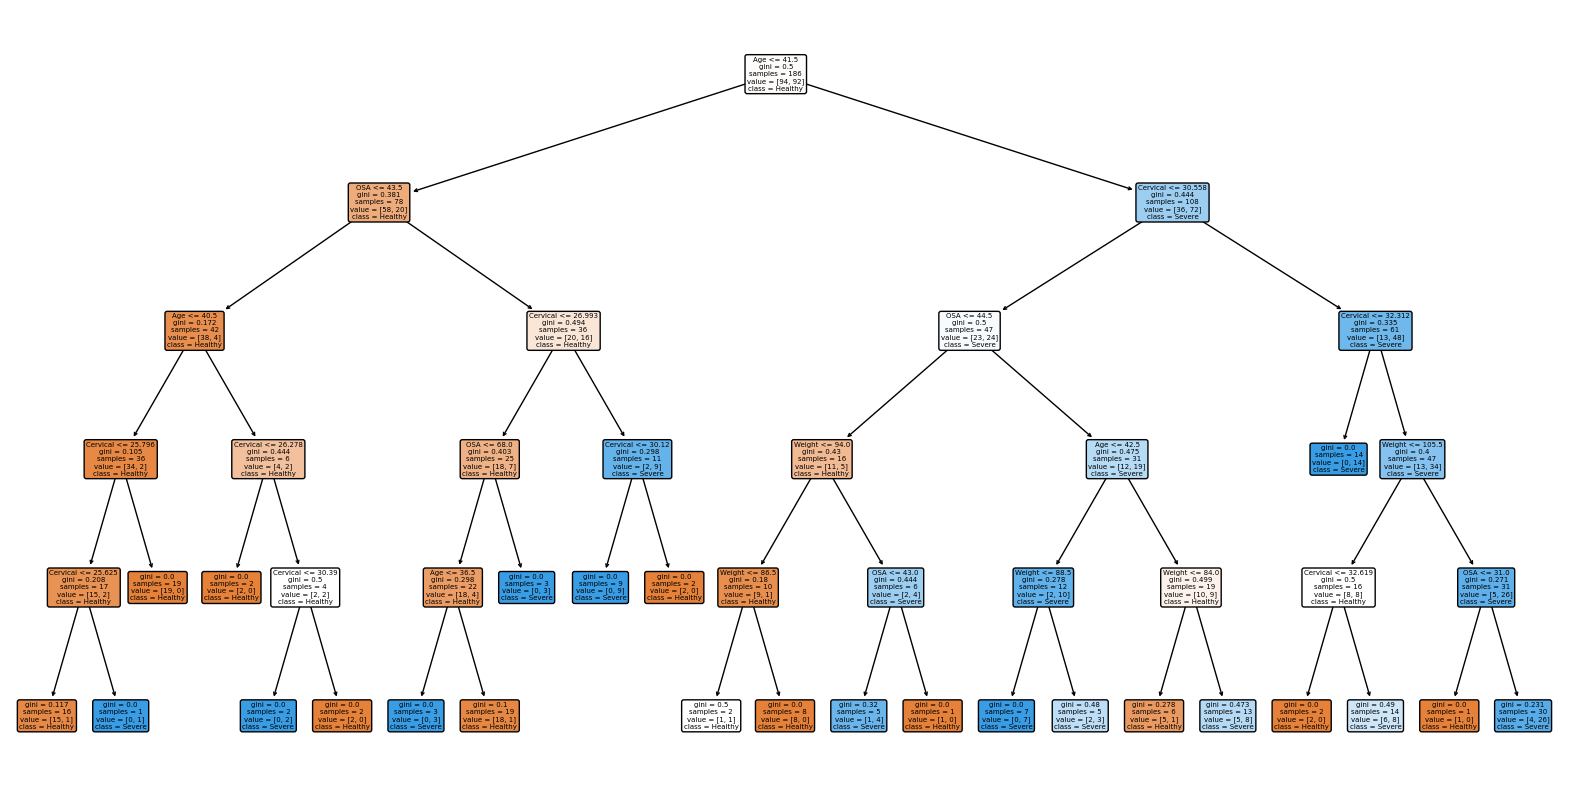

<Figure size 640x480 with 0 Axes>

In [15]:
# Dibuja el árbol
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(20, 10))
plot_tree(final_best_model_tree, filled=True, feature_names=df_male.columns[:-1], class_names=["Healthy", "Severe"], rounded=True)
plt.show()
plt.savefig(r'C:\Users\Usuario\universidad\MUIT\2º\MLLB\OSA CASE STUDY\Report\Images\Decision Tree\male\tree_male.png')

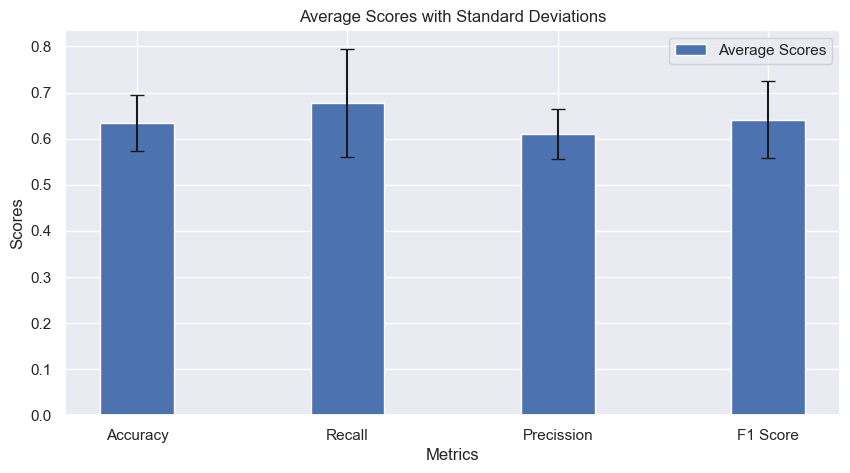

In [233]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_tree[metric] for metric in metrics]
std_dev_scores = [std_score_tree[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

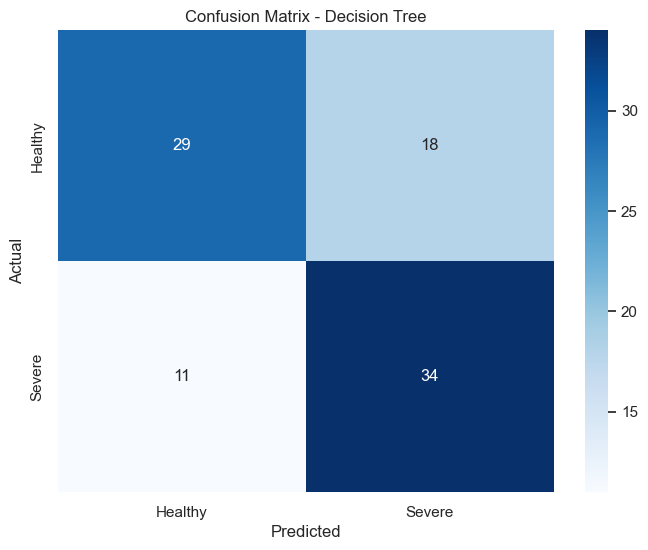

In [30]:
plot_confusion_matrix(cm_tree, classes=['Healthy', 'Severe'], title='Confusion Matrix - Decision Tree')

### Random Forest with Nested Cross Validation

In [31]:
from sklearn import preprocessing, metrics

# Define el modelo
scorer_forest = metrics.make_scorer(accuracy_score)
model_forest = RandomForestClassifier(random_state=1)

# Define el espacio de búsqueda
space_forest = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Realiza la búsqueda de cuadrícula y obtén los resultados
final_best_model_forest, final_best_params_forest, avg_score_forest, std_score_forest, outer_results_forest, cm_forest = nested_kfolds(X=X, y=y, space=space_forest, scorer=scorer_forest, model=model_forest)

# Imprime los resultados
print("Final Best Parameters:", final_best_params_forest)
print("Final Best Model:", final_best_model_forest)
print("Average Scores:", avg_score_forest)
print("Standard Deviations of Scores:", std_score_forest)
print("Confussion Matrix:", cm_forest)


>Accuracy=0.667, Recall=0.711, Precission=0.640, F1 Score=0.674
>Accuracy=0.699, Recall=0.702, Precission=0.702, F1 Score=0.702
>Accuracy=0.707, Recall=0.756, Precission=0.680, F1 Score=0.716
Accuracy: 0.691 (0.017)
Recall: 0.723 (0.023)
Precission: 0.674 (0.026)
F1 Score: 0.697 (0.018)
Final Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Final Best Model: RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       random_state=1)
Average Scores: {'Accuracy': 0.6907043789932992, 'Recall': 0.7229314420803782, 'Precission': 0.6740425531914894, 'F1 Score': 0.6972004479283315}
Standard Deviations of Scores: {'Accuracy': 0.0172778729953, 'Recall': 0.023358441520625703, 'Precission': 0.025710956165383714, 'F1 Score': 0.017538934923064905}
Confussion Matrix: [[31 16]
 [11 34]]


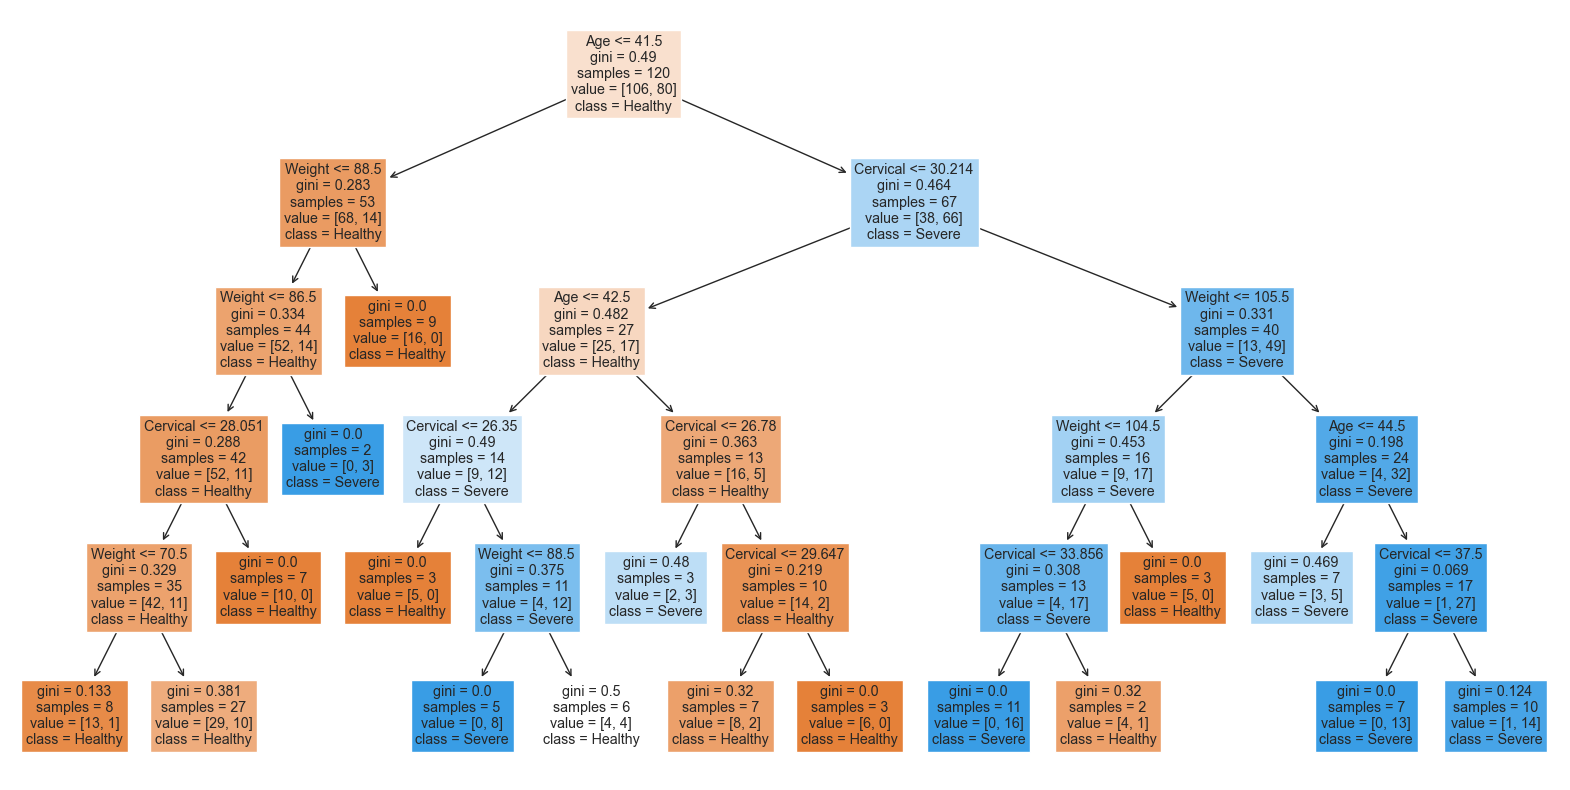

In [235]:
tree_index = 0

# Get the selected tree
selected_tree = final_best_model_forest.estimators_[tree_index]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(selected_tree, filled=True, feature_names=df_male.columns[:-1], class_names=['Healthy', 'Severe'])
plt.show()

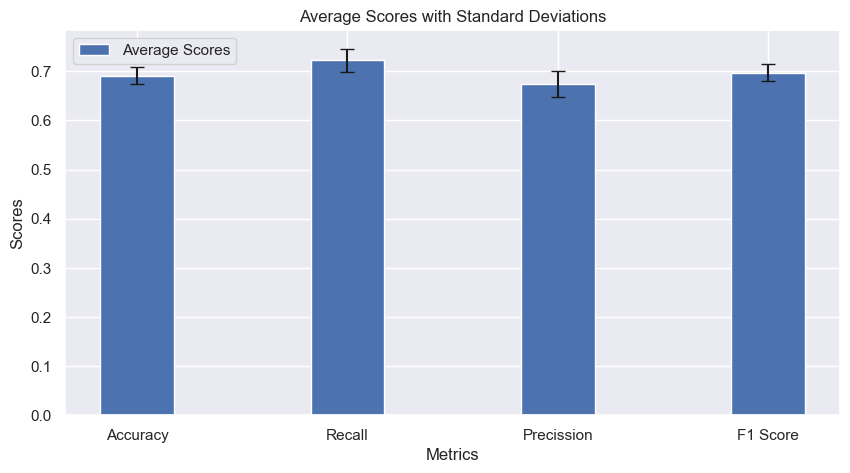

In [236]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_forest[metric] for metric in metrics]
std_dev_scores = [std_score_forest[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

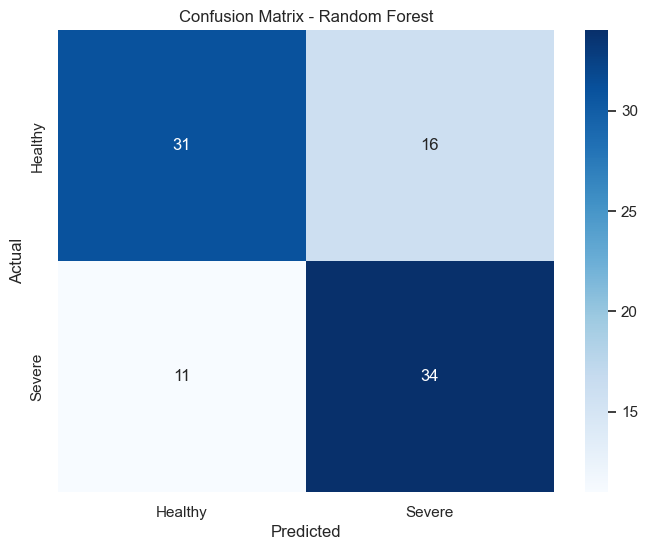

In [32]:
plot_confusion_matrix(cm_forest, classes=['Healthy', 'Severe'], title='Confusion Matrix - Random Forest')

### AdaBoost

In [33]:
from sklearn import preprocessing, metrics

# Define the model
scorer_adaboost = metrics.make_scorer(accuracy_score)
model_adaboost = AdaBoostClassifier(random_state=1)

# Define the space for hyperparameter tuning
space_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Perform nested cross-validation and obtain the results
final_best_model_adaboost, final_best_params_adaboost, avg_score_adaboost, std_score_adaboost, outer_results_adaboost, cm_adaboost = nested_kfolds(
    X=X, y=y, space=space_adaboost, scorer=scorer_adaboost, model=model_adaboost
)

# Print the results
print("Final Best Parameters (AdaBoost):", final_best_params_adaboost)
print("Final Best Model (AdaBoost):", final_best_model_adaboost)
print("Average Scores (AdaBoost):", avg_score_adaboost)
print("Standard Deviations of Scores (AdaBoost):", std_score_adaboost)
print("Confussion Matrix:", cm_adaboost)


>Accuracy=0.688, Recall=0.756, Precission=0.654, F1 Score=0.701
>Accuracy=0.742, Recall=0.787, Precission=0.725, F1 Score=0.755
>Accuracy=0.652, Recall=0.622, Precission=0.651, F1 Score=0.636
Accuracy: 0.694 (0.037)
Recall: 0.722 (0.071)
Precission: 0.677 (0.034)
F1 Score: 0.697 (0.049)
Final Best Parameters (AdaBoost): {'learning_rate': 0.1, 'n_estimators': 100}
Final Best Model (AdaBoost): AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=1)
Average Scores (AdaBoost): {'Accuracy': 0.6940938133083995, 'Recall': 0.7216706067769897, 'Precission': 0.6768330468740865, 'F1 Score': 0.6974988683383381}
Standard Deviations of Scores (AdaBoost): {'Accuracy': 0.036883468943400395, 'Recall': 0.0714999651632994, 'Precission': 0.034423235718208885, 'F1 Score': 0.04853904789760438}
Confussion Matrix: [[32 15]
 [17 28]]


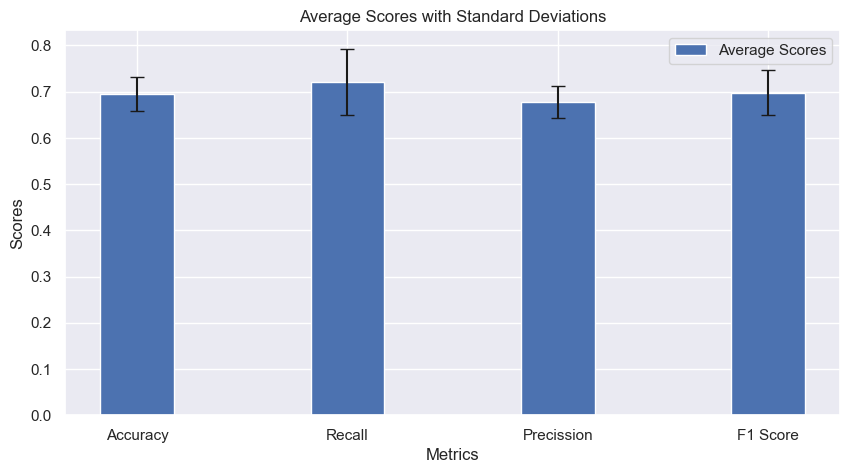

In [238]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_adaboost[metric] for metric in metrics]
std_dev_scores = [std_score_adaboost[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

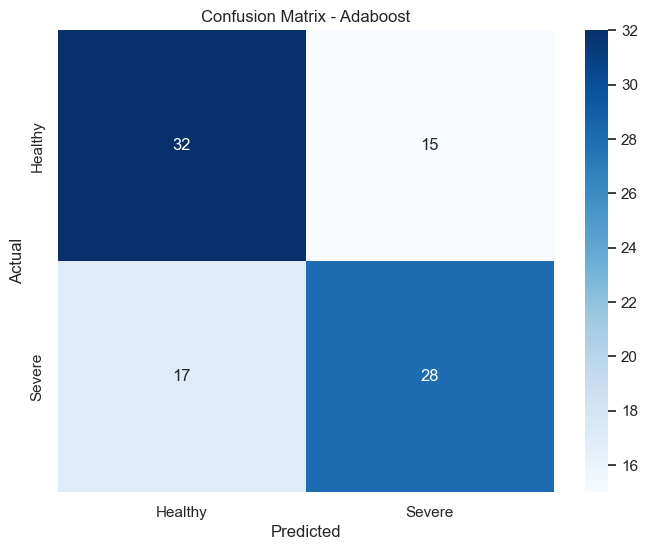

In [34]:
plot_confusion_matrix(cm_adaboost, classes=['Healthy', 'Severe'], title='Confusion Matrix - Adaboost')

### Gradient Boost Tree

In [35]:
from sklearn import preprocessing, metrics

# Define the model
scorer_gradient = metrics.make_scorer(accuracy_score)
model_gradient = GradientBoostingClassifier(random_state=1)

# Define the space for hyperparameter tuning
space_gradient = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7]
}

# Perform nested cross-validation and obtain the results
final_best_model_gradient, final_best_params_gradient, avg_score_gradient, std_score_gradient, outer_results_gradient, cm_gradient = nested_kfolds(
    X=X, y=y, space=space_gradient, scorer=scorer_gradient, model=model_gradient
)

# Print the results
print("Final Best Parameters (AdaBoost):", final_best_params_gradient)
print("Final Best Model (AdaBoost):", final_best_model_gradient)
print("Average Scores (AdaBoost):", avg_score_gradient)
print("Standard Deviations of Scores (AdaBoost):", std_score_gradient)
print("Confussion Matrix:", cm_gradient)

>Accuracy=0.624, Recall=0.644, Precission=0.604, F1 Score=0.624
>Accuracy=0.677, Recall=0.745, Precission=0.660, F1 Score=0.700
>Accuracy=0.707, Recall=0.733, Precission=0.688, F1 Score=0.710
Accuracy: 0.669 (0.034)
Recall: 0.707 (0.045)
Precission: 0.651 (0.035)
F1 Score: 0.678 (0.038)
Final Best Parameters (AdaBoost): {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 100}
Final Best Model (AdaBoost): GradientBoostingClassifier(learning_rate=1.0, max_depth=5, random_state=1)
Average Scores (AdaBoost): {'Accuracy': 0.6691990026492131, 'Recall': 0.7074862096138692, 'Precission': 0.6506813417190775, 'F1 Score': 0.6777777777777777}
Standard Deviations of Scores (AdaBoost): {'Accuracy': 0.03432556760509093, 'Recall': 0.04481733040107475, 'Precission': 0.03470466507580647, 'F1 Score': 0.03847332597331529}
Confussion Matrix: [[32 15]
 [12 33]]


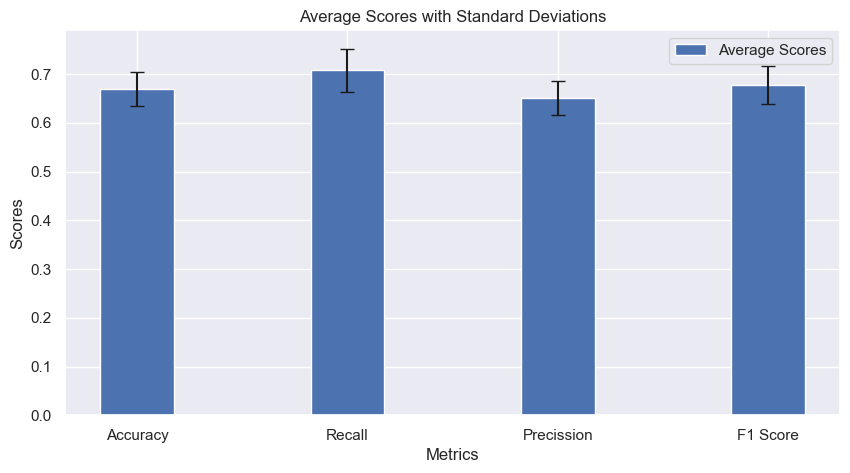

In [240]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_gradient[metric] for metric in metrics]
std_dev_scores = [std_score_gradient[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

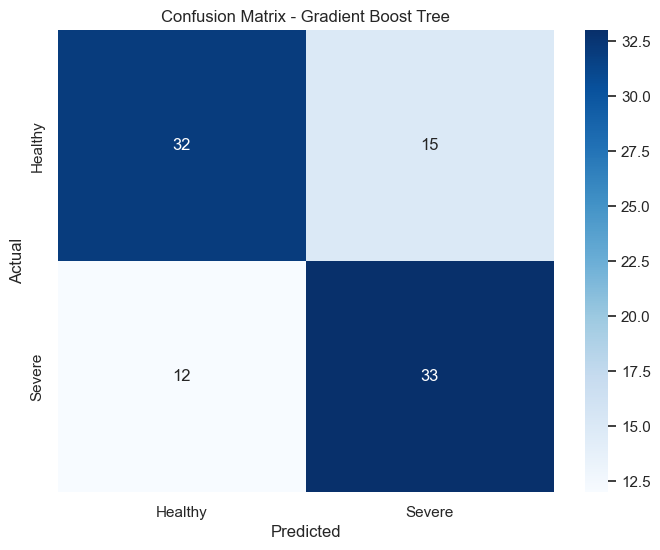

In [36]:
plot_confusion_matrix(cm_gradient, classes=['Healthy', 'Severe'], title='Confusion Matrix - Gradient Boost Tree')

### Support Vector Classifier

In [37]:
from sklearn import preprocessing, metrics

# Define the model
scorer_svc = metrics.make_scorer(accuracy_score)
model_svc = SVC(random_state=1)

# Define the space for hyperparameter tuning
space_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
}

# Perform nested cross-validation and obtain the results
final_best_model_svc, final_best_params_svc, avg_score_svc, std_score_svc, outer_results_svc, cm_svc = nested_kfolds(
    X=X, y=y, space=space_svc, scorer=scorer_svc, model=model_svc
)

# Print the results
print("Final Best Parameters (AdaBoost):", final_best_params_svc)
print("Final Best Model (AdaBoost):", final_best_model_svc)
print("Average Scores (AdaBoost):", avg_score_svc)
print("Standard Deviations of Scores (AdaBoost):", std_score_svc)
print("Confussion Matrix:", cm_svc)

>Accuracy=0.667, Recall=0.578, Precission=0.684, F1 Score=0.627
>Accuracy=0.753, Recall=0.723, Precission=0.773, F1 Score=0.747
>Accuracy=0.707, Recall=0.600, Precission=0.750, F1 Score=0.667
Accuracy: 0.709 (0.035)
Recall: 0.634 (0.064)
Precission: 0.736 (0.038)
F1 Score: 0.680 (0.050)
Final Best Parameters (AdaBoost): {'C': 1, 'degree': 3, 'kernel': 'poly'}
Final Best Model (AdaBoost): SVC(C=1, kernel='poly', random_state=1)
Average Scores (AdaBoost): {'Accuracy': 0.7086255259467041, 'Recall': 0.6337273443656423, 'Precission': 0.7356459330143541, 'F1 Score': 0.6801418126719331}
Standard Deviations of Scores (AdaBoost): {'Accuracy': 0.03514962575456844, 'Recall': 0.0640568396491004, 'Precission': 0.03753516598329283, 'F1 Score': 0.05020708753517581}
Confussion Matrix: [[38  9]
 [18 27]]


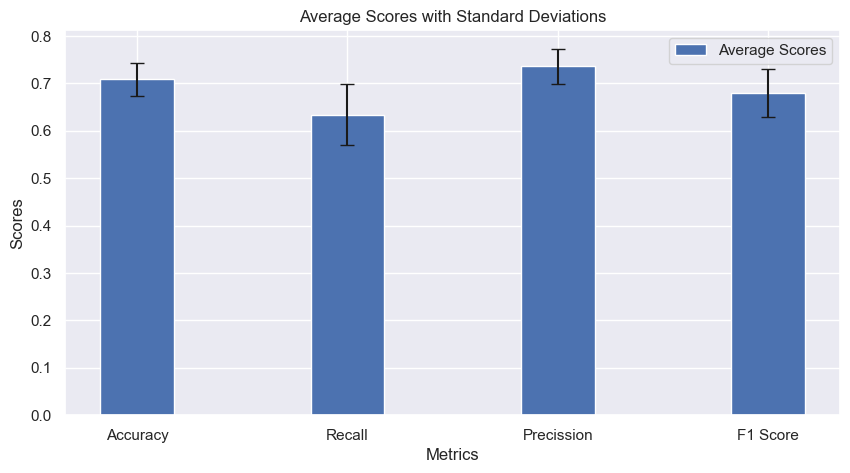

In [242]:
metrics = ['Accuracy', 'Recall', 'Precission', 'F1 Score']
average_scores = [avg_score_svc[metric] for metric in metrics]
std_dev_scores = [std_score_svc[metric] for metric in metrics]

plot_scores(metrics, average_scores, std_dev_scores)

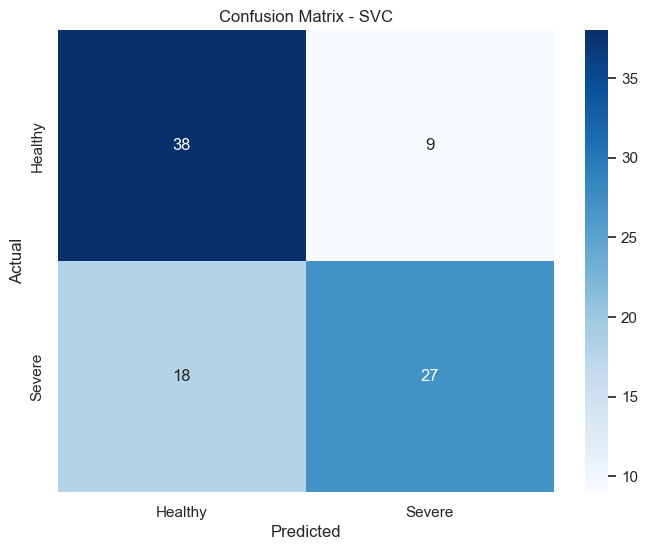

In [38]:
plot_confusion_matrix(cm_svc, classes=['Healthy', 'Severe'], title='Confusion Matrix - SVC')

### Model Comparision

In this section we are going to draw all the accuracies of each model in order to conclude which model is best.

[0.7086255259467041, 0.7158329437431822, 0.6799516908212562, 0.6943275673990962, 0.6332787907121707, 0.6907043789932992, 0.6940938133083995, 0.6691990026492131, 0.7086255259467041]


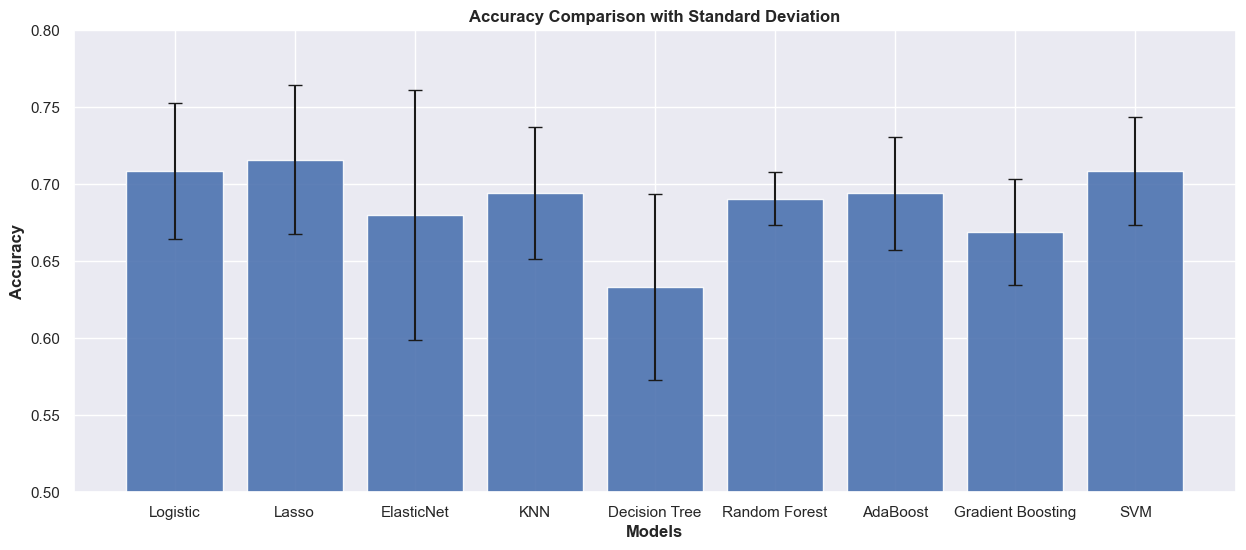

In [246]:
# Lista de nombres de modelos
model_names = ['Logistic', 'Lasso', 'ElasticNet', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM']

# Lista de puntuaciones de accuracy
avg_scores = [avg_score_logistic, avg_score_lasso, avg_score_elastic, avg_score_knn, avg_score_tree, avg_score_forest, avg_score_adaboost, avg_score_gradient, avg_score_svc]
std_scores = [std_score_logistic, std_score_lasso, std_score_elastic, std_score_knn, std_score_tree, std_score_forest, std_score_adaboost, std_score_gradient, std_score_svc]

accuracy_scores = [score['Accuracy'] for score in avg_scores]
std_scores = [score['Accuracy'] for score in std_scores]
print(accuracy_scores)

# Barplot con barras de error
plt.figure(figsize=(15, 6))
plt.bar(model_names, accuracy_scores, alpha=0.9, yerr=std_scores, capsize=5)
plt.title('Accuracy Comparison with Standard Deviation', fontweight='bold')
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.ylim(0.5, 0.8)  # Ajusta el rango del eje y según tus necesidades
plt.show()

Now we are going to compare the F1 Scores

Average F1 Scores: [0.6881516309138996, 0.7007267799950728, 0.6692691622103387, 0.6995147443075774, 0.6409291089253055, 0.6972004479283315, 0.6974988683383381, 0.6777777777777777, 0.6801418126719331]


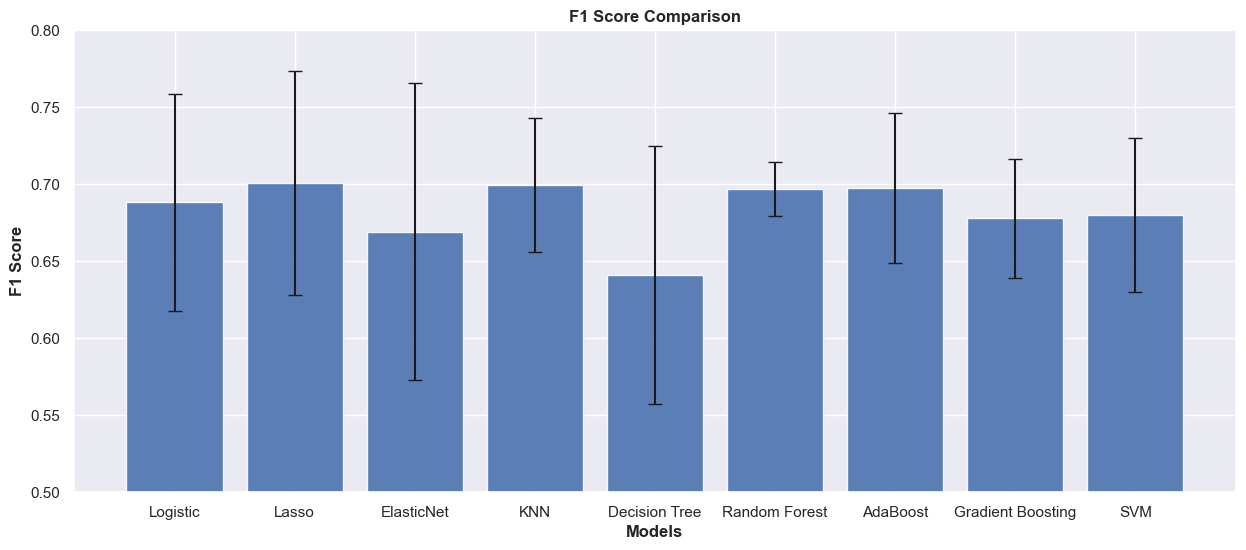

In [247]:
# Lista de nombres de modelos
model_names = ['Logistic', 'Lasso', 'ElasticNet', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVM']

# Lista de puntuaciones de accuracy
avg_scores =[avg_score_logistic, avg_score_lasso, avg_score_elastic, avg_score_knn, avg_score_tree, avg_score_forest, avg_score_adaboost, avg_score_gradient, avg_score_svc]
std_scores = [std_score_logistic, std_score_lasso, std_score_elastic, std_score_knn, std_score_tree, std_score_forest, std_score_adaboost, std_score_gradient, std_score_svc]

f1_scores = [score['F1 Score'] for score in avg_scores]
std_scores = [score['F1 Score'] for score in std_scores]
print("Average F1 Scores:", f1_scores)

# Barplot
plt.figure(figsize=(15, 6))
plt.bar(model_names, f1_scores, alpha=0.9, yerr=std_scores, capsize=5)
plt.title('F1 Score Comparison', fontweight = 'bold')
plt.xlabel('Models', fontweight = 'bold')
plt.ylabel('F1 Score', fontweight = 'bold')
plt.ylim(0.5, 0.8)  # Ajusta el rango del eje y según tus necesidades
plt.show()